In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
@dataclass
class ThermalParams:
    h: float  # Heat loss coefficient (kW/°C)
    C: float  # Thermal capacitance (kWh/°C)
    P_max: float  # Maximum heater power (kW)

# Define thermal model

In [3]:
def estimate_thermal_parameters(df: pd.DataFrame, dt: float = 0.25) -> tuple:
    """
    Estimate thermal parameters from experimental data.

    This is done with linear regression:

    \Delta T = \alpha \cdot P - \beta \cdot (T_{\text{indoor}} - T_{\text{ambient}})

    \alpha = \frac{1}{C}

    \beta = \frac{h}{C}

    """
    df = df.copy()

    df["dT"] = df["current_temp_c"].shift(-1) - df["current_temp_c"]
    df["T_diff"] = df["current_temp_c"] - df["ambient_temp_c"]
    df["P_kW"] = df["watts_on"] / 1000

    df = df.dropna(subset=["dT", "T_diff", "P_kW"])

    # Linear regression: dT = α×P + β×T_diff
    X = df[["P_kW", "T_diff"]].values
    y = df["dT"].values

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    alpha = model.coef_[0]  # dt / C
    beta = -model.coef_[1]  # h × dt / C

    C = dt / alpha if alpha > 0 else 1.0
    h = beta / alpha if alpha > 0 else 0.02

    h = np.clip(h, 0.01, 0.1)
    C = np.clip(C, 0.1, 2.0)

    return h, C, model.score(X, y)


def simulate_thermal_step(
    T_in: float, T_out: float, P: float, params: ThermalParams, dt: float = 0.25
) -> float:
    dT = (P - params.h * (T_in - T_out)) / params.C * dt
    return T_in + dT

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
/var/folders/fh/lmktpsyd2f99h77_8mhvt4xw0000gn/T/ipykernel_68983/339519852.py:7: SyntaxWarning: invalid escape sequence '\D'
  \Delta T = \alpha \cdot P - \beta \cdot (T_{\text{indoor}} - T_{\text{ambient}})


In [4]:
class HysteresisController:
    def __init__(self, T_min: float, T_max: float, P_max: float):
        self.T_min = T_min
        self.T_max = T_max
        self.P_max = P_max
        self.heater_on = False

    def get_power(self, T_current: float) -> float:
        if T_current <= self.T_min:
            self.heater_on = True
        elif T_current >= self.T_max:
            self.heater_on = False
        return self.P_max if self.heater_on else 0.0


class DPController:
    def __init__(
        self,
        T_min: float,
        T_max: float,
        P_max: float,
        params: ThermalParams,
        steps_per_hour: int = 4,
    ):
        self.T_min = T_min
        self.T_max = T_max
        self.P_max = P_max
        self.params = params
        self.steps_per_hour = steps_per_hour
        self.dt = 1.0 / steps_per_hour

        self.grid_step = 0.05  # Temperature discretization (°C)
        self.grid_pad = 2.0  # Padding beyond comfort bounds (°C)
        self.penalty_scale = 5000  # Penalty for constraint violations

    def solve(
        self,
        T_initial: float,
        T_outdoor: np.ndarray,
        prices: np.ndarray,
        horizon_hours: int = 24,
    ) -> list:
        """
        Solve for optimal heating schedule using backward DP.

        Args:
            T_initial: Starting indoor temperature (°C)
            T_outdoor: Hourly outdoor temperatures (°C)
            prices: Hourly electricity prices (EUR/kWh)
            horizon_hours: Planning horizon (hours)

        Returns:
            List of power values for each 15-min timestep
        """
        n_hours = min(horizon_hours, len(prices), len(T_outdoor))
        n_steps = n_hours * self.steps_per_hour

        # Interpolate outdoor temps to timestep resolution
        T_out = np.repeat(T_outdoor[:n_hours], self.steps_per_hour)

        # Build temperature state space
        grid_min = self.T_min - self.grid_pad
        grid_max = self.T_max + self.grid_pad
        temps = np.arange(grid_min, grid_max + self.grid_step, self.grid_step)
        n_states = len(temps)

        def temp_to_idx(temp: float) -> int:
            """Map temperature to grid index."""
            idx = int(np.round((temp - grid_min) / self.grid_step))
            return max(0, min(n_states - 1, idx))

        def compute_penalty(T: float) -> float:
            """Cubic penalty for constraint violations."""
            if T < self.T_min:
                return self.penalty_scale * (self.T_min - T) ** 3
            elif T > self.T_max:
                return self.penalty_scale * (T - self.T_max) ** 3
            return 0.0

        # Energy consumed per timestep when heater is ON
        energy_per_step = self.P_max * self.dt

        # Value function V[t, s] = min cost-to-go from state s at time t
        V = np.zeros((n_steps + 1, n_states))

        # Policy π[t, s] = optimal action (0=OFF, 1=ON) at state s, time t
        policy = np.zeros((n_steps, n_states), dtype=np.int32)

        # === BACKWARD PASS ===
        for t in range(n_steps - 1, -1, -1):
            hour_idx = t // self.steps_per_hour
            price = prices[min(hour_idx, len(prices) - 1)]
            T_ambient = T_out[t]

            for s in range(n_states):
                T = temps[s]

                # Evaluate OFF action
                T_next_off = simulate_thermal_step(
                    T, T_ambient, 0, self.params, self.dt
                )
                cost_off = (
                    compute_penalty(T_next_off) + V[t + 1, temp_to_idx(T_next_off)]
                )

                # Evaluate ON action
                T_next_on = simulate_thermal_step(
                    T, T_ambient, self.P_max, self.params, self.dt
                )
                cost_on = (
                    energy_per_step * price
                    + compute_penalty(T_next_on)
                    + V[t + 1, temp_to_idx(T_next_on)]
                )

                # Choose minimum cost action
                if cost_on < cost_off:
                    V[t, s] = cost_on
                    policy[t, s] = 1
                else:
                    V[t, s] = cost_off
                    policy[t, s] = 0

        # === FORWARD PASS: Extract optimal schedule ===
        schedule = []
        s = temp_to_idx(T_initial)

        for t in range(n_steps):
            action = policy[t, s]
            P = self.P_max if action else 0.0
            schedule.append(P)

            # Simulate transition to next state
            T = temps[s]
            T_next = simulate_thermal_step(T, T_out[t], P, self.params, self.dt)
            s = temp_to_idx(T_next)

        return schedule


In [5]:
def simulate_day(
    T_outdoor: np.ndarray,
    prices: np.ndarray,
    params: ThermalParams,
    T_min: float,
    T_max: float,
    T_initial: float,
    controller_type: str = "hysteresis",
) -> dict:
    """
    Simulate one day of heating.
    """
    STEPS_PER_HOUR = 4
    DT = 0.25  # hours

    n_hours = min(24, len(prices), len(T_outdoor))
    n_steps = n_hours * STEPS_PER_HOUR

    # Interpolate outdoor temps to 15-min resolution
    T_out = np.repeat(T_outdoor[:n_hours], STEPS_PER_HOUR)

    # Initialize controller
    if controller_type == "hysteresis":
        controller = HysteresisController(T_min, T_max, params.P_max)
        schedule = None
    else:
        dp = DPController(T_min, T_max, params.P_max, params, STEPS_PER_HOUR)
        schedule = dp.solve(T_initial, T_outdoor, prices, n_hours)

    # Run simulation
    T = T_initial
    total_cost = 0.0
    total_energy = 0.0

    for step in range(n_steps):
        hour_idx = step // STEPS_PER_HOUR
        price = prices[min(hour_idx, len(prices) - 1)]

        # Get control action
        if controller_type == "hysteresis":
            P = controller.get_power(T)
        else:
            P = schedule[step] if step < len(schedule) else 0.0

        # Accumulate cost and energy
        energy = P * DT
        total_energy += energy
        total_cost += energy * price

        # Update temperature
        T = simulate_thermal_step(T, T_out[step], P, params, DT)

    # Compute average price paid
    avg_price = total_cost / total_energy if total_energy > 0 else 0.0

    return {
        "total_cost": total_cost,
        "total_energy": total_energy,
        "avg_price_paid": avg_price,
    }

# Run monte carlo to test random days

In [6]:
def run_monte_carlo(
    df_weather: pd.DataFrame,
    params: ThermalParams,
    T_min: float,
    T_max: float,
    n_simulations: int,
    seed: int,
) -> pd.DataFrame:
    day_counts = df_weather.groupby("date").size()
    complete_days = day_counts[day_counts >= 24].index.tolist()

    # Sample random days
    np.random.seed(seed)
    n_samples = min(n_simulations, len(complete_days))
    sample_days = np.random.choice(complete_days, size=n_samples, replace=False)

    results = []

    for day in sample_days:
        day_data = (
            df_weather[df_weather["date"] == day].sort_values("datetime_dk").head(24)
        )

        if len(day_data) < 24:
            continue

        T_outdoor = day_data["temp_mean_past1h"].values
        prices = day_data["price_eur_kwh"].values
        T_initial = (T_min + T_max) / 2

        res_hyst = simulate_day(
            T_outdoor, prices, params, T_min, T_max, T_initial, "hysteresis"
        )
        res_dp = simulate_day(T_outdoor, prices, params, T_min, T_max, T_initial, "dp")

        # Compute savings
        if res_hyst["total_cost"] > 0.001:
            savings_pct = (1 - res_dp["total_cost"] / res_hyst["total_cost"]) * 100
            energy_savings_pct = (
                1 - res_dp["total_energy"] / res_hyst["total_energy"]
            ) * 100
        else:
            savings_pct = 0
            energy_savings_pct = 0

        results.append(
            {
                "date": day,
                "mean_temp": np.mean(T_outdoor),
                "mean_price": np.mean(prices),
                "price_range": np.max(prices) - np.min(prices),
                "hyst_cost": res_hyst["total_cost"],
                "dp_cost": res_dp["total_cost"],
                "hyst_energy": res_hyst["total_energy"],
                "dp_energy": res_dp["total_energy"],
                "savings_pct": savings_pct,
                "savings_eur": res_hyst["total_cost"] - res_dp["total_cost"],
                "energy_savings_pct": energy_savings_pct,
            }
        )

    return pd.DataFrame(results)


In [ ]:
# Color palette (Framna styling)
FRAMNA_BACKGROUND = "#FFFFFF"
FRAMNA_BLACK = "#000000"
FRAMNA_GREEN = "#1CB65D"
FRAMNA_BLUE = "#E3EFF1"
FRAMNA_RED = "#B20126"
COLOR_PRIMARY = "#457b9d"
COLOR_ACCENT = "#e63946"


def style_ax(ax, xlabel, ylabel, title):
    """Apply common axis styling."""
    ax.set_facecolor(FRAMNA_BLUE)
    ax.set_xlabel(xlabel, fontsize=12, fontweight="medium")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="medium")
    ax.set_title(title, fontsize=14, fontweight="semibold", pad=20)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


EXPERIMENT_FILE = "../data/raw/experiment_dp.csv"
WEATHER_FILE = "../data/raw/processed_municipality_combined.csv"
OUTPUT_DIR = "../results/simulation"

T_MIN = 20.0 # Minimum comfort temperature (°C)
T_MAX = 24.0 # Maximum comfort temperature (°C)
N_SIMULATIONS = 1000
HEATING_DAYS_PER_YEAR = 180

EXPERIMENTAL_SAVINGS_PCT = 8.71

df_experiment = pd.read_csv(EXPERIMENT_FILE)
df_weather = pd.read_csv(WEATHER_FILE)

h, C, r2 = estimate_thermal_parameters(df_experiment)
print("Estimated thermal parameters:")
print(f"- h = {h:.4f} kW/°C (heat loss coefficient)")
print(f"- C = {C:.2f} kWh/°C (thermal capacitance)")
print(f"- Tau = {C / h:.1f} hours (time constant)")
print(f"- R^2 = {r2:.3f}")

P_max = df_experiment[df_experiment["watts_on"] > 100]["watts_on"].median() / 1000
params = ThermalParams(h=h, C=C, P_max=P_max)
print("Found P_max = ", P_max, "kW")

df_weather["price_eur_kwh"] = df_weather["price_eur_mwh"] / 1000
df_weather["date"] = pd.to_datetime(df_weather["datetime_dk"]).dt.date
df_weather["month"] = pd.to_datetime(df_weather["datetime_dk"]).dt.month

# Filter to heating season
df_heating = df_weather[
    (df_weather["month"].isin([1, 2, 3, 4, 10, 11, 12]))
    & (df_weather["temp_mean_past1h"] < 15)
    & (df_weather["temp_mean_past1h"] > -20)
    & (df_weather["price_eur_mwh"] > 0)
].copy()

# Run Monte Carlo simulation
random_seed = 42
df_results = run_monte_carlo(df_heating, params, T_MIN, T_MAX, N_SIMULATIONS, random_seed)

savings = df_results["savings_pct"].values
mask = np.abs(savings - np.mean(savings)) < 3 * np.std(savings)
savings_clean = savings[mask]

mu, std = stats.norm.fit(savings_clean)
ci_95 = stats.norm.interval(0.95, loc=mu, scale=std / np.sqrt(len(savings_clean)))
_, p_value = stats.ttest_1samp(savings_clean, 0)

# Annual projection
savings_eur = df_results["savings_eur"].values[mask]
annual_savings = np.mean(savings_eur) * HEATING_DAYS_PER_YEAR
annual_std = np.std(savings_eur) * np.sqrt(HEATING_DAYS_PER_YEAR)

print(f"""
SAVINGS DISTRIBUTION:
─ Mean:   {mu:.2f}%
─ Std:    {std:.2f}%
─ 95% CI: [{ci_95[0]:.2f}%, {ci_95[1]:.2f}%]
─ p-value: {p_value:.2e}

EXPERIMENTAL VALIDATION:
─ Experimental: {EXPERIMENTAL_SAVINGS_PCT:.2f}%
─ Simulated: {mu:.2f}%
─ Percentile: {stats.percentileofscore(savings_clean, EXPERIMENTAL_SAVINGS_PCT):.1f}th

ANNUAL PROJECTION ({HEATING_DAYS_PER_YEAR} days):
─ Expected: €{annual_savings:.2f}/year
─ 95% CI: [€{annual_savings - 1.96 * annual_std:.2f}, €{annual_savings + 1.96 * annual_std:.2f}]/year
""")

df_results.to_csv(f"{OUTPUT_DIR}/simulation_results.csv", index=False)


Estimated thermal parameters:
- h = 0.0222 kW/°C (heat loss coefficient)
- C = 0.29 kWh/°C (thermal capacitance)
- Tau = 13.1 hours (time constant)
- R^2 = 0.469
    h = 0.0222 kW/°C (heat loss coefficient)
    C = 0.29 kWh/°C (thermal capacitance)
    Tau = 13.1 hours (time constant)
    R^2 = 0.469
[5] Analyzing results...

SAVINGS DISTRIBUTION:
─ Mean:   21.37%
─ Std:    12.89%
─ 95% CI: [20.45%, 22.29%]
─ p-value: 3.99e-217

EXPERIMENTAL VALIDATION:
─ Experimental: 8.71%
─ Simulated: 21.37%
─ Percentile: 14.8th

ANNUAL PROJECTION (180 days):
─ Expected: €31.89/year
─ 95% CI: [€28.10, €35.68]/year



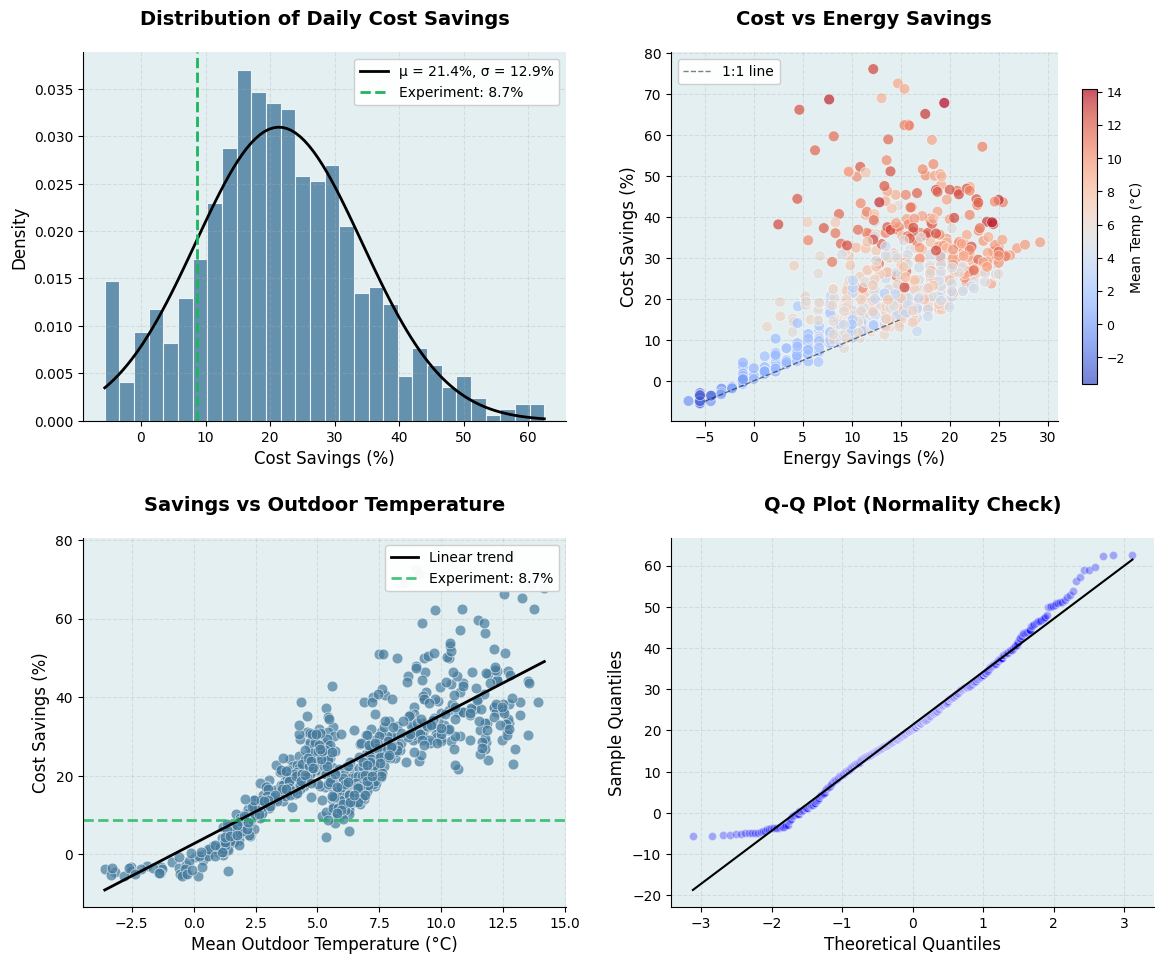

In [8]:
output_path = f"{OUTPUT_DIR}/savings_analysis.png"
experimental_savings = EXPERIMENTAL_SAVINGS_PCT
savings = df_results["savings_pct"].values

# Remove outliers for fitting
mask = np.abs(savings - np.mean(savings)) < 3 * np.std(savings)
savings_clean = savings[mask]
mu, std = stats.norm.fit(savings_clean)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.set_facecolor(FRAMNA_BACKGROUND)

# Plot 1: Distribution with normal fit
ax1 = axes[0, 0]
ax1.hist(
    savings_clean,
    bins=30,
    density=True,
    alpha=0.8,
    color=COLOR_PRIMARY,
    edgecolor="white",
    linewidth=0.8,
)
x = np.linspace(savings_clean.min(), savings_clean.max(), 100)
ax1.plot(
    x,
    stats.norm.pdf(x, mu, std),
    color=FRAMNA_BLACK,
    lw=2,
    label=f"μ = {mu:.1f}%, σ = {std:.1f}%",
)
ax1.axvline(
    experimental_savings,
    color=FRAMNA_GREEN,
    linestyle="--",
    lw=2,
    label=f"Experiment: {experimental_savings:.1f}%",
)
style_ax(ax1, "Cost Savings (%)", "Density", "Distribution of Daily Cost Savings")
ax1.legend(loc="upper right", fontsize=10, framealpha=0.95)

# Plot 2: Cost vs Energy Savings
ax2 = axes[0, 1]
scatter = ax2.scatter(
    df_results["energy_savings_pct"],
    df_results["savings_pct"],
    alpha=0.7,
    c=df_results["mean_temp"],
    cmap="coolwarm",
    edgecolors="white",
    linewidth=0.5,
    s=60,
)
ax2.plot([-5, 15], [-5, 15], color=FRAMNA_BLACK, linestyle="--", lw=1, alpha=0.5, label="1:1 line")
style_ax(ax2, "Energy Savings (%)", "Cost Savings (%)", "Cost vs Energy Savings")
ax2.legend(loc="upper left", fontsize=10, framealpha=0.95)
cb = plt.colorbar(scatter, ax=ax2, shrink=0.8)
cb.set_label("Mean Temp (°C)", fontsize=10)
cb.ax.tick_params(labelsize=9)

# Plot 3: Savings vs Outdoor Temperature
ax3 = axes[1, 0]
ax3.scatter(
    df_results["mean_temp"],
    df_results["savings_pct"],
    alpha=0.7,
    color=COLOR_PRIMARY,
    edgecolors="white",
    linewidth=0.5,
    s=60,
)
z = np.polyfit(df_results["mean_temp"], df_results["savings_pct"], 1)
x_trend = np.linspace(
    df_results["mean_temp"].min(), df_results["mean_temp"].max(), 100
)
ax3.plot(x_trend, np.poly1d(z)(x_trend), color=FRAMNA_BLACK, lw=2, label="Linear trend")
ax3.axhline(experimental_savings, color=FRAMNA_GREEN, linestyle="--", lw=2, alpha=0.8, label=f"Experiment: {experimental_savings:.1f}%")
style_ax(ax3, "Mean Outdoor Temperature (°C)", "Cost Savings (%)", "Savings vs Outdoor Temperature")
ax3.legend(loc="upper right", fontsize=10, framealpha=0.95)

# Plot 4: Q-Q Plot
ax4 = axes[1, 1]
ax4.set_facecolor(FRAMNA_BLUE)
stats.probplot(savings_clean, dist="norm", plot=ax4)
# Style the Q-Q plot points and line
ax4.get_lines()[0].set_markerfacecolor('blue')
ax4.get_lines()[0].set_markeredgecolor("white")
ax4.get_lines()[0].set_markersize(6)
ax4.get_lines()[0].set_alpha(0.3)
ax4.get_lines()[1].set_color(FRAMNA_BLACK)
ax4.set_xlabel("Theoretical Quantiles", fontsize=12, fontweight="medium")
ax4.set_ylabel("Sample Quantiles", fontsize=12, fontweight="medium")
ax4.set_title("Q-Q Plot (Normality Check)", fontsize=14, fontweight="semibold", pad=20)
ax4.grid(True, alpha=0.3, linestyle="--")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.tight_layout(pad=2.0)
plt.savefig(
    output_path,
    dpi=200,
    bbox_inches="tight",
    facecolor=FRAMNA_BACKGROUND,
    edgecolor="none",
)
plt.show()